---
<h1 style="text-align: center;">BrainScanNet: Diagnósticos Inteligentes Para Tumores Cerebrais Usando IA</h1>

*Discente:*

    *   Gabriel D'assumpção de Carvalho - gdc2@cin.ufpe.br
    *   Leandro Freitas - lllf@cin.ufpe.br
    *   Lucas Sales - lfasm@cin.ufpe.br

---
---

# Bibliotecas utilizadas

In [75]:
# Informações do sistema
import os
import shutil

# Banco de dados
from kagglehub import dataset_download

# Manipulação de dados
import pandas as pd
import numpy as np
from torchvision.datasets import ImageFolder
from collections import Counter
from torchvision import transforms
from PIL import Image
from torch.utils.data import random_split
from torch.utils.data import DataLoader

# Deep Learning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Gráficos
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import cv2
from captum.attr import LayerGradCam, LayerAttribution
from graphviz import Digraph

# Desativar warnings
import warnings
warnings.filterwarnings("ignore")

# Estilo Gráficos
plt.style.use("ggplot")
colors = sns.color_palette("pastel")

# Global SEED
SEED=42

# Setting seed for consistent results
np.random.seed(SEED)

# Definir a seed para o PyTorch
torch.manual_seed(SEED)

# Se estiver usando GPU
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # Se houver múltiplas GPUs

# Para tornar as operações determinísticas (reproduzíveis)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Importação dos dados

In [2]:
path = dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

In [3]:
# Listar os arquivos e pastas dentro do diretório dataset
train_path = os.path.join(path, "Training")
test_path = os.path.join(path, "Testing")

In [4]:
# Carregar dataset de treino
train = ImageFolder(root=train_path)
# Carregar dataset de teste
test = ImageFolder(root=test_path)

# Análise Exploratória dos Dados - Gabriel



Nesta seção, analisaremos detalhadamente o conjunto de treinamento, comparando-o com a quantidade de dados de teste. Também exploraremos a distribuição e verificação de imagens de cada classe, além de gráficos que examinam a resolução das imagens, o tamanho em KB e a distribuição da iluminação dos pixels e do contraste.

Essa etapa é essencial, pois permitirá a aplicação de transformações para padronizar as imagens de entrada e normalizar os pixels, melhorando a distribuição de iluminação e contraste no conjunto de treinamento. Além disso, discutiremos posteriormente a aplicação de técnicas de *data augmentation* para aumentar a diversidade das imagens, o que será abordado no próximo tópico.

In [5]:
# Extrair todas as classes do dataset
labels = [label for _, label in train]

In [6]:
# Obter lista de nomes das classes (pastas dentro do train_path)
tumor_classes = sorted(os.listdir(train_path))

# Criar um dicionário para mapear classes numéricas para nomes de tumores
class_map = {i: tumor_classes[i] for i in range(len(tumor_classes))}

# Contar a distribuição das classes
class_counts = Counter(labels)

# Criar DataFrame para exibição organizada
df_summary = pd.DataFrame({
    "Tumor": [class_map[i] for i in class_counts.keys()],
    "Classe": class_counts.keys(),
    "Observacoes": class_counts.values()
})

# Ordenar pelo número da classe (opcional)
df_summary = df_summary.sort_values(by="Classe").reset_index(drop=True)

# Salvar como CSV (opcional)
# df_summary.to_csv("brain_tumor_summary.csv", index=False)

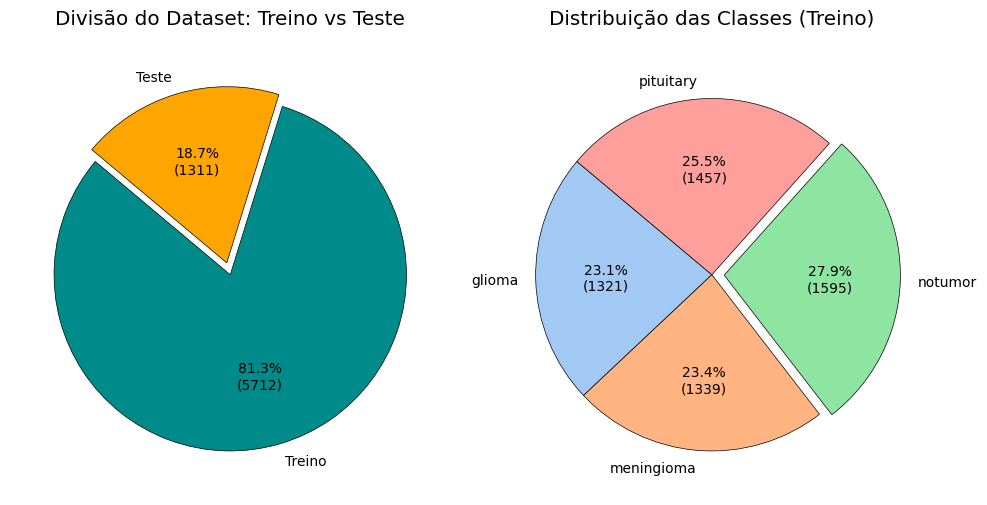

In [7]:
# Função para formatar os rótulos com porcentagem e total de observações
def format_labels(pct, all_values):
    total = int(round(pct / 100.0 * sum(all_values)))
    return f"{pct:.1f}%\n({total})"

# Definir cores para os gráficos
colors = sns.color_palette("pastel")

# Criar subplots para os gráficos de pizza
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

## GRÁFICO 2: Distribuição das Classes
axes[1].pie(
    df_summary.Observacoes,
    labels=df_summary.Tumor,
    autopct=lambda pct: format_labels(pct, df_summary.Observacoes),
    startangle=140,
    colors=colors,
    explode=[0,0,0.07, 0],
    wedgeprops={"edgecolor": "black"}
)
axes[1].set_title("Distribuição das Classes (Treino)\n")

## GRÁFICO 1: Distribuição Treino vs Teste
train_size = len(train)
test_size = len(test)

axes[0].pie(
    [train_size, test_size],
    labels=["Treino", "Teste"],
    autopct=lambda pct: format_labels(pct, [train_size, test_size]),
    startangle=140,
    explode=[0, 0.07],
    colors=['darkcyan', 'orange'],
    wedgeprops={"edgecolor": "black"}
)
axes[0].set_title("Divisão do Dataset: Treino vs Teste\n")

# Ajustar layout
plt.tight_layout()
plt.show()


Como pode ser observado no gráfico de pizza acima, o banco de dados está dividido em 18,7% (1.311 imagens) para teste e 81,3% (5.712 imagens) para treino, totalizando 6.523 imagens. Essa divisão é bastante equilibrada. Os dados de teste não serão analisados além da sua quantidade, a fim de evitar a introdução de qualquer viés nesta análise.

Além disso, os dados de treino apresentam uma distribuição homogênea entre as quatro classes: 27,5% (1.595) de ressonâncias sem tumor, 25,5% (1.457) com tumor pituitário, 23,4% (1.339) com meningioma e 23,1% (1.321) com glioma. Dessa forma, não será necessário aplicar técnicas de balanceamento de classes.

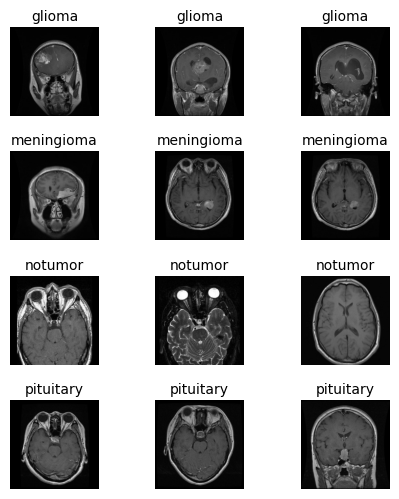

In [8]:
import matplotlib.pyplot as plt

def show_sample_images(train, class_names, class_sizes, num_samples=3, im_size=350, figsize=(12, 10)):
    """
    Exibe imagens do conjunto de treino, pegando 'num_samples' de cada classe.
    """
    fig, axes = plt.subplots(len(class_names), num_samples, figsize=figsize)

    start_idx = 0  # Índice inicial para cada classe
    for i, (class_name, class_size) in enumerate(zip(class_names, class_sizes)):
        sample_indices = list(range(start_idx, start_idx + class_size))  # Índices da classe
        selected_indices = sample_indices[:num_samples]  # Pegamos 4 exemplos da classe

        for j, idx in enumerate(selected_indices):
            img, _ = train[idx]  # Pegamos a imagem (ignora o rótulo)
            ax = axes[i, j] if len(class_names) > 1 else axes[j]
            ax.imshow(img.resize((im_size, im_size)), cmap="gray")
            ax.set_title(f'{class_name}', fontsize=10, pad=5)
            ax.axis("off")

        start_idx += class_size  # Avança para a próxima classe

    plt.subplots_adjust(wspace=-0.7, hspace=0.4)
    plt.show()

# Exibir 4 imagens de cada tumor
show_sample_images(train, tumor_classes, df_summary.Observacoes, num_samples=3, im_size=350, figsize=(10, 6))


Acima, podemos ver três exemplos de cada classe. Observa-se que as ressonâncias não foram realizadas de forma padronizada, apresentando variações na posição em que as imagens foram capturadas. Portanto, é possível que a classe com maior variação nas ressonâncias apresente uma menor acurácia. Caso isso ocorra, serão propostas melhorias na etapa de experimentação do modelo.

A seguir, serão analisados os metadados das imagens com mais detalhes, levantando possíveis técnicas de pré-processamento que possam melhorar o desempenho do modelo de CNN.


In [9]:
# Listas para armazenar as larguras e alturas
widths = []
heights = []

# Percorre todas as imagens do dataset
for img, _ in train:
    width, height = img.size  # Obtém largura e altura da imagem
    widths.append(width)
    heights.append(height)

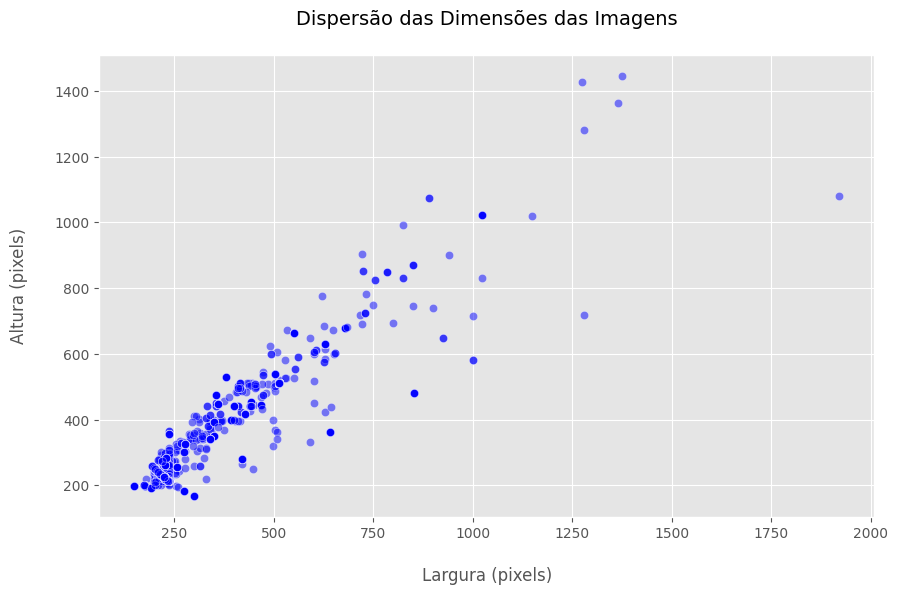

In [10]:
# Criando o scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=widths, y=heights, alpha=0.5, color="blue")

# Adicionando rótulos e título
plt.title("Dispersão das Dimensões das Imagens\n", fontsize=14)
plt.xlabel("\nLargura (pixels)", fontsize=12)
plt.ylabel("Altura (pixels)\n", fontsize=12)

# Exibir gráfico
plt.show()


No gráfico acima, podemos observar a dispersão da resolução das imagens. Como é possível notar, as imagens apresentam diferentes dimensões, com a maioria concentrada na faixa de altura [200, 600] e largura [200, 500]. No entanto, há alguns outliers com dimensões muito grandes.

Como este trabalho propõe a utilização de uma arquitetura de rede neural convolucional (CNN), que exige alto poder computacional, será necessário reduzir a dimensão das imagens. Essa redução ajudará a diminuir a quantidade de operações de convolução nas primeiras camadas da rede, além de padronizar a entrada do modelo. Na próxima seção, será definida uma padronização de tamanho adequada, de forma a equilibrar a redução da quantidade de parâmetros da rede sem comprometer o desempenho do modelo.

In [11]:
# Criar uma lista com os modos das imagens
image_modes = [img.mode for img, _ in train]

# Verificar quantos modos diferentes existem
unique_modes = set(image_modes)

print("Modos de cor encontrados:", unique_modes)

# Verificar se todas são RGB
if unique_modes == {"RGB"}:
    print("✅ Todas as imagens do treino estão no modo RGB.")
else:
    print("⚠️ Existem imagens com outros modos de cor!")

Modos de cor encontrados: {'RGB'}
✅ Todas as imagens do treino estão no modo RGB.


In [12]:
# Criar uma lista com os modos das imagens
image_modes = [img.mode for img, _ in test]

# Verificar quantos modos diferentes existem
unique_modes = set(image_modes)

print("Modos de cor encontrados:", unique_modes)

# Verificar se todas são RGB
if unique_modes == {"RGB"}:
    print("✅ Todas as imagens do teste estão no modo RGB.")
else:
    print("⚠️ Existem imagens com outros modos de cor!")

Modos de cor encontrados: {'RGB'}
✅ Todas as imagens do teste estão no modo RGB.


Além da transformação da resolução das imagens, será aplicada a conversão do canal de cores de RGB para escala de cinza, resultando em apenas um canal. Essa conversão contribuirá para a otimização das operações de convolução na primeira camada da rede, reduzindo a complexidade computacional sem comprometer a qualidade das imagens.

No caso das ressonâncias magnéticas, apesar de estarem no formato RGB, sua visualização é essencialmente em tons de preto e branco. Portanto, a conversão para escala de cinza não acarretará perda de informação relevante para o modelo.

In [13]:
# Lista para armazenar os tamanhos das imagens em KB
image_sizes = []

# Obter todos os caminhos das imagens dentro de train_path
for root, _, files in os.walk(train_path):  # Percorre a estrutura de diretórios
    for file in files:
        image_path = os.path.join(root, file)  # Cria o caminho completo da imagem
        image_sizes.append(os.path.getsize(image_path) / 1024)  # Adiciona o tamanho em KB


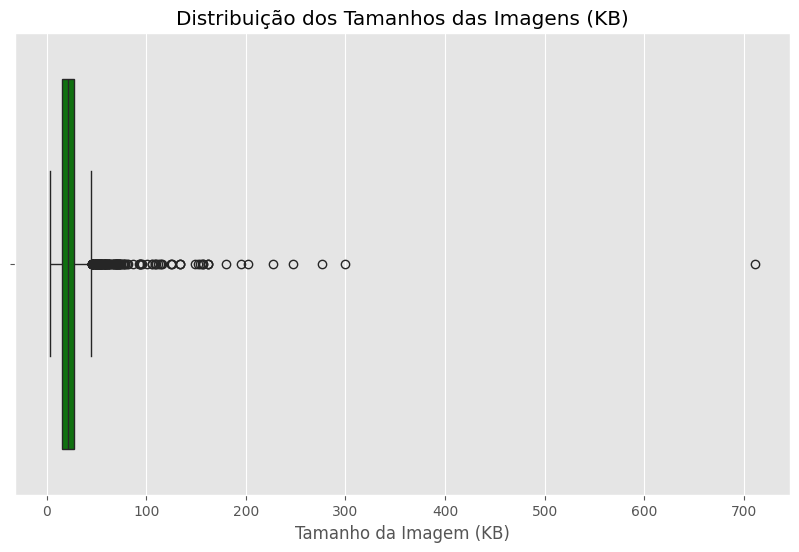

In [14]:
# Criar o boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=image_sizes, color="green")

# Adicionar rótulos8
plt.title("Distribuição dos Tamanhos das Imagens (KB)")
plt.xlabel("Tamanho da Imagem (KB)")

# Exibir gráfico
plt.show()

No boxplot acima, observamos que o terceiro quartil está aproximadamente em 40 KB, indicando que 75% (4.284) das imagens do conjunto de treinamento possuem um tamanho igual ou inferior a esse valor.

Entretanto, nota-se a presença de diversos outliers, com algumas imagens atingindo cerca de 700 KB. Essas imagens de maior tamanho serão ajustadas durante o pré-processamento, quando forem convertidas para escala de cinza (reduzindo para um único canal) e padronizadas em termos de largura e altura. Essa padronização ajudará a reduzir a variação no tamanho das imagens e otimizar o desempenho computacional do modelo.


In [15]:
# Converter as imagens para escala de cinza e calcular o brilho médio
brightness_values = [np.array(img.convert("L")).mean() for img, _ in train]

# Converter para grayscale e calcular o desvio padrão dos pixels
std_devs = [np.array(img.convert("L")).std() for img, _ in train]

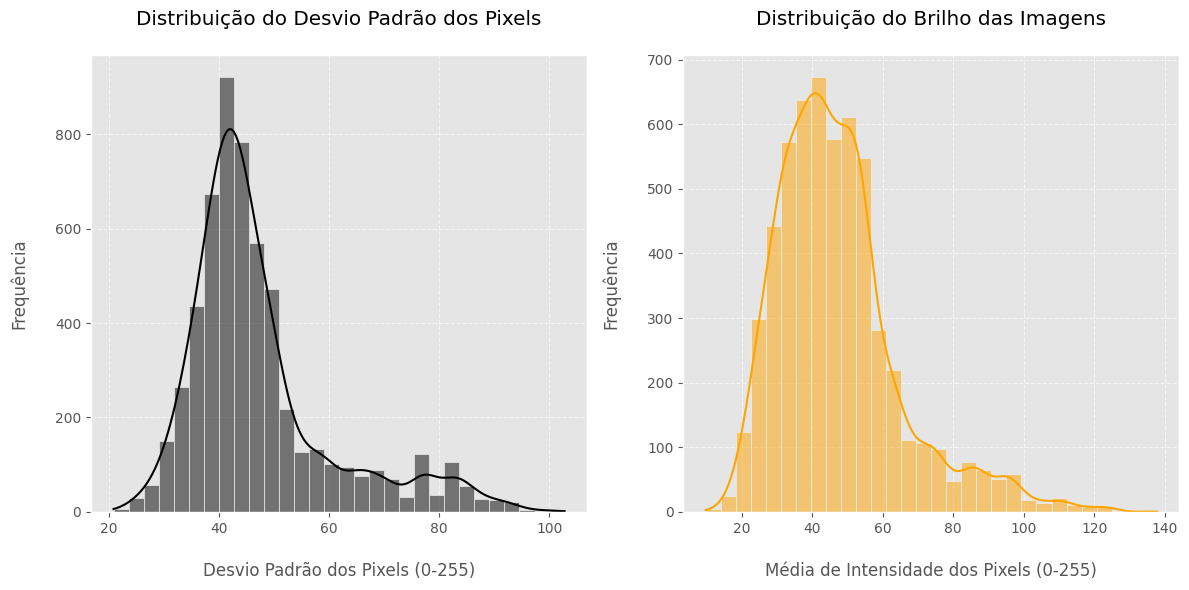

In [16]:
# Criar uma figura com dois subgráficos lado a lado
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Histograma do Desvio Padrão
sns.histplot(std_devs, bins=30, kde=True, color="black", ax=axes[0])
axes[0].set_title("Distribuição do Desvio Padrão dos Pixels\n")
axes[0].set_xlabel("\nDesvio Padrão dos Pixels (0-255)")
axes[0].set_ylabel("Frequência\n")
axes[0].grid(True, linestyle="--", alpha=0.6)

# Histograma do Brilho
sns.histplot(brightness_values, bins=30, kde=True, color="orange", ax=axes[1])
axes[1].set_title("Distribuição do Brilho das Imagens\n")
axes[1].set_xlabel("\nMédia de Intensidade dos Pixels (0-255)")
axes[1].set_ylabel("Frequência\n")
axes[1].grid(True, linestyle="--", alpha=0.6)

# Ajustar espaçamento entre os gráficos
plt.tight_layout()
plt.show()

Nos histogramas acima, podemos observar a distribuição do desvio padrão dos pixels das ressonâncias (em preto, à esquerda) e a distribuição da média dos pixels, que representa o brilho das imagens (em laranja, à direita). Ambas as distribuições apresentam assimetria positiva, indicando que a maioria das imagens possui valores de desvio padrão e média entre **20 e 60**, embora algumas observações apresentem valores significativamente mais elevados.

O desvio padrão dos pixels reflete o nível de contraste das imagens. Nota-se que a maior parte das ressonâncias possui **contraste baixo a moderado**, situando-se nos intervalos **[20, 40]** e **[40, 60]**, respectivamente. No entanto, há um pico de aproximadamente **150 observações** com desvio padrão em torno de **80**, sugerindo a presença de ressonâncias com alto contraste.

O histograma de brilho apresenta um comportamento semelhante ao do desvio padrão. Valores baixos indicam imagens predominantemente escuras, com grande parte dos pixels na cor preta, sugerindo uma menor área de tecido cerebral visível. Por outro lado, imagens com altos níveis de brilho correspondem a ressonâncias em que o tecido cerebral ocupa uma maior área da imagem e apresenta tons de branco mais intensos.

A seguir, serão apresentadas as imagens com os maiores e menores valores de desvio padrão e iluminação para uma análise visual mais detalhada.

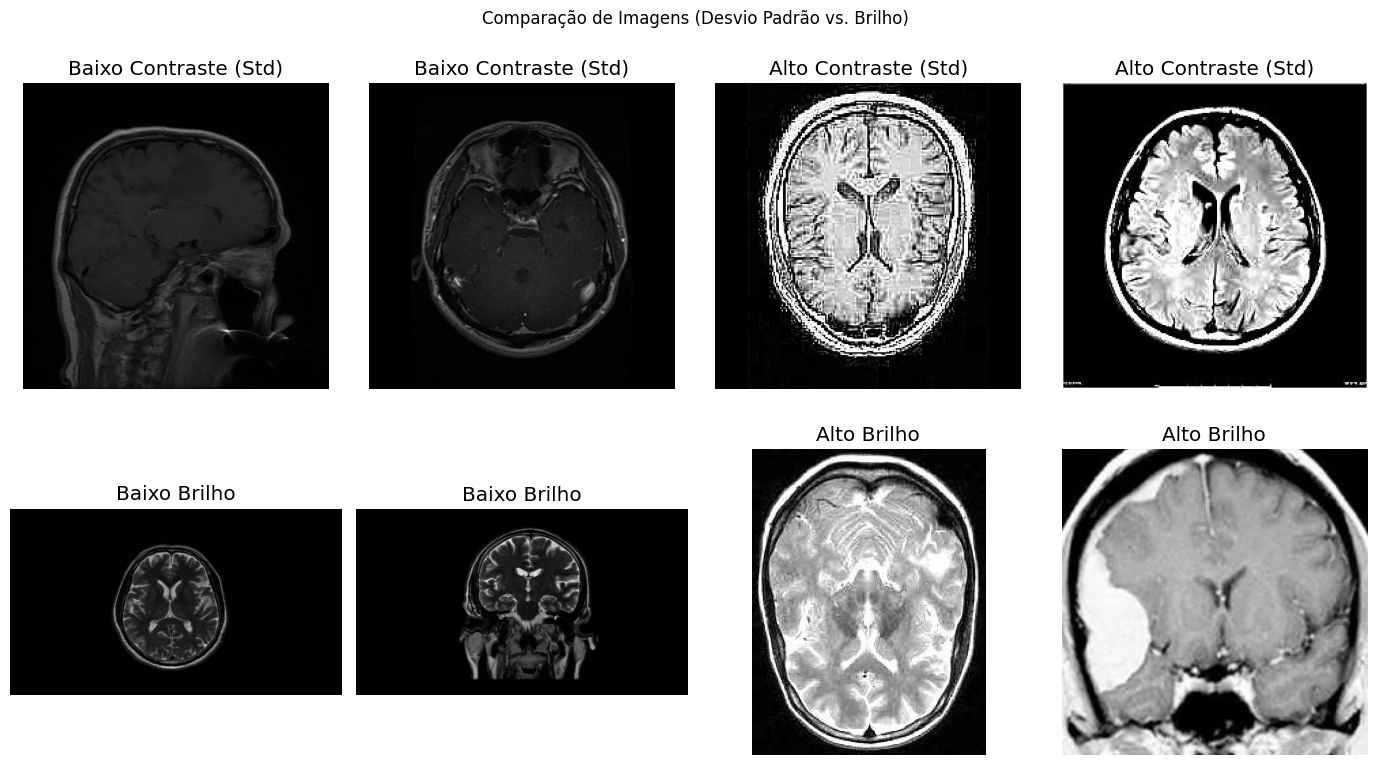

In [17]:
# Criar uma figura com dois conjuntos de subplots lado a lado
fig, axes = plt.subplots(2, 4, figsize=(14, 8))  # Aumentei o figsize para acomodar

# *** Primeiro Conjunto de Imagens (Baseado no Desvio Padrão) ***

# Ordenar imagens pelo desvio padrão
sorted_indices_std = np.argsort(std_devs)

# Pegar 2 imagens com menor e maior desvio padrão
low_contrast_std = [train[idx][0] for idx in sorted_indices_std[:2]]
high_contrast_std = [train[idx][0] for idx in sorted_indices_std[-2:]]

# Plotar as imagens
for i, img in enumerate(low_contrast_std):
    axes[0, i].imshow(img, cmap="gray")
    axes[0, i].set_title("Baixo Contraste (Std)") # Adicionado (Std) para distinguir
    axes[0, i].axis("off")

for i, img in enumerate(high_contrast_std):
    axes[0, i + 2].imshow(img, cmap="gray")  # Deslocamento para a direita
    axes[0, i + 2].set_title("Alto Contraste (Std)") # Adicionado (Std) para distinguir
    axes[0, i + 2].axis("off")

# *** Segundo Conjunto de Imagens (Baseado no Brilho) ***

# Ordenar imagens pelo valor de brilho
sorted_indices_brightness = np.argsort(brightness_values)

# Pegar 2 imagens com menor e maior valor de brilho
low_brightness = [train[idx][0] for idx in sorted_indices_brightness[:2]]
high_brightness = [train[idx][0] for idx in sorted_indices_brightness[-2:]]

# Plotar as imagens
for i, img in enumerate(low_brightness):
    axes[1, i].imshow(img, cmap="gray")
    axes[1, i].set_title("Baixo Brilho") # Alterado o titulo
    axes[1, i].axis("off")

for i, img in enumerate(high_brightness):
    axes[1, i + 2].imshow(img, cmap="gray")  # Deslocamento para a direita
    axes[1, i + 2].set_title("\n\nAlto Brilho") # Alterado o titulo
    axes[1, i + 2].axis("off")

plt.suptitle("Comparação de Imagens (Desvio Padrão vs. Brilho)")  # Título geral
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajusta o layout para o título não sobrepor

plt.show()

Na imagem acima, podemos observar quatro exemplos de ressonâncias magnéticas: duas com **baixo brilho e contraste** e duas com **alto brilho e contraste**.  

As ressonâncias de **baixo contraste** apresentam poucos detalhes estruturais, tornando difícil a distinção das regiões cerebrais. Essas imagens tendem a ser mais escuras, com menos variação nos tons de cinza. Em contrapartida, as imagens de **alto contraste** exibem uma riqueza maior de informações sobre os tecidos cerebrais, mas também podem conter **ruídos**, possivelmente resultantes de artefatos de captura ou processamento.  

Quando analisamos o **brilho**, as imagens com **baixo brilho** possuem uma grande área predominantemente escura, onde o fundo preto ocupa a maior parte da imagem. Já nas imagens de **alto brilho**, a maior parte da composição visual é formada pelo tecido cerebral, tornando os detalhes mais evidentes.  

Para mitigar essa variação na distribuição de **desvio padrão e média de intensidade**, podemos aplicar a **normalização Z-score**, reduzindo discrepâncias no brilho e contraste dos pixels.


# Pre-processamento dos dados

In [18]:
# Definir transformações com data augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(5),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.1854], std=[0.1793])])


Os dados estão bem balanceados, porém, identificamos dois principais desafios: a falta de padronização na resolução das imagens e a presença de algumas com brilho e contraste excessivos. Para mitigar esses problemas, as imagens foram redimensionadas para 224x224 e normalizadas utilizando o Z-score, garantindo maior uniformidade nos valores dos pixels e reduzindo o impacto de variações extremas de iluminação. Além disso, aplicamos uma rotação aleatória de até 5 graus para introduzir leve ruído e aumentar a robustez do modelo.

In [19]:
# Carregar o dataset com a transformação necessária
full_dataset = ImageFolder(root=train_path, transform=transform)

# Definir as proporções para treino e validação
train_size = int(0.8 * len(full_dataset))  # 80% para treinamento
val_size = len(full_dataset) - train_size  # 20% para validação

# Dividir o dataset em treino e validação
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Criar DataLoaders para o treino e validação
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [20]:
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.1854], std=[0.1793])])

test = ImageFolder(root=test_path, transform=transform_test)
test_loader = DataLoader(test, batch_size=32, shuffle=False)

Os dados foram divididos em 80% para treinamento e 20% para validação, permitindo avaliar a capacidade de generalização dos modelos antes de selecionar o melhor para a inferência nos dados de teste. No entanto, antes da aplicação no conjunto de teste, é essencial padronizá-lo para garantir a consistência do modelo. Para isso, as imagens são redimensionadas para 224x224 e normalizadas utilizando o Z-score, com média de 0.1854 e desvio padrão de 0.1793.

# BrainScanNet - Lucas

In [79]:
224-3+1

222

In [81]:
111 - 3 + 1

109

In [94]:
256 * 14 * 14, 256

(50176, 256)

In [21]:
# Definição do modelo BrainScanNet
class BrainScanNet(nn.Module):
    def __init__(self, num_classes=4):
        super(BrainScanNet, self).__init__()
        # Bloco 1: de 1 canal para 32 filtros
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)

        # Bloco 2: 32 -> 64 filtros
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)

        # Bloco 3: 64 -> 128 filtros
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm2d(128)

        # Bloco 4: 128 -> 256 filtros
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4   = nn.BatchNorm2d(256)

        # Pooling e Dropout
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)

        # Após 4 blocos de convolução com pooling (224 -> 112 -> 56 -> 28 -> 14)
        self.fc1 = nn.Linear(256 * 14 * 14, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # Sem softmax: a CrossEntropyLoss aplica log-softmax internamente
        return x

# Instanciar e mover o modelo para o dispositivo (GPU se disponível)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BrainScanNet(num_classes=4).to(device)
print("BrainScanNet:")
print(model)

BrainScanNet:
BrainScanNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=50176, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=4, bias=True)
)


In [22]:
# Pasta que vai conter os modelos treinados
models_dir = "models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

Definição do Modelo BrainScanNet

Neste bloco é definido o modelo BrainScanNet, uma rede neural convolucional projetada como baseline, que será utilizada para classificar tumores cerebrais em 4 categorias:

* Glioma
* Meningioma
* Hipófise
* Ausência de tumor
* O modelo é composto por 4 blocos convolucionais, sendo que cada camada convolucional é seguida por Batch Normalization e função de ativação ReLU.

Cada bloco dobra o número de filtros convolucionais, permitindo que o modelo aprenda características mais complexas e detalhadas das imagens a cada camada mais profunda.

Após cada camada convolucional, é aplicado um Max Pooling para reduzir a dimensão espacial dos dados e uma camada de Dropout com taxa de 0.5 é aplicada para reduzir o risco de overfitting.

Por fim, após a extração das características nas camadas convolucionais, o modelo possui camadas totalmente conectadas (Fully Connected) com uma camada intermediária de 256 neurônios que sintetizam características globais (bordas, texturas, formas), seguida de uma camada final com 4 neurônios, correspondente às classes que desejamos classificar.

In [23]:
criterion = nn.CrossEntropyLoss()  # Função de perda
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Otimizador Adam
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)  # Redução do LR

num_epochs = 25  # Número de épocas
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    # Fase de treinamento
    model.train()
    running_loss, correct_train = 0.0, 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_train_acc = correct_train / total_train
    train_losses.append(epoch_train_loss)
    train_accs.append(epoch_train_acc)

    # Fase de validação
    model.eval()
    val_running_loss, correct_val = 0.0, 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    epoch_val_loss = val_running_loss / len(val_loader.dataset)
    epoch_val_acc = correct_val / total_val
    val_losses.append(epoch_val_loss)
    val_accs.append(epoch_val_acc)

    scheduler.step(epoch_val_loss)

    print(f"Época {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f} - Train Acc: {epoch_train_acc:.4f} - Val Loss: {epoch_val_loss:.4f} - Val Acc: {epoch_val_acc:.4f}")

Época 1/25 - Train Loss: 1.6160 - Train Acc: 0.6389 - Val Loss: 0.5866 - Val Acc: 0.7454
Época 2/25 - Train Loss: 0.5168 - Train Acc: 0.7978 - Val Loss: 0.4544 - Val Acc: 0.8145
Época 3/25 - Train Loss: 0.4166 - Train Acc: 0.8391 - Val Loss: 0.3533 - Val Acc: 0.8434
Época 4/25 - Train Loss: 0.3446 - Train Acc: 0.8658 - Val Loss: 0.2757 - Val Acc: 0.9046
Época 5/25 - Train Loss: 0.2855 - Train Acc: 0.8893 - Val Loss: 0.2447 - Val Acc: 0.8976
Época 6/25 - Train Loss: 0.2620 - Train Acc: 0.8969 - Val Loss: 0.2954 - Val Acc: 0.8836
Época 7/25 - Train Loss: 0.2350 - Train Acc: 0.9111 - Val Loss: 0.3059 - Val Acc: 0.8898
Época 8/25 - Train Loss: 0.1923 - Train Acc: 0.9280 - Val Loss: 0.2234 - Val Acc: 0.9213
Época 9/25 - Train Loss: 0.1886 - Train Acc: 0.9291 - Val Loss: 0.1874 - Val Acc: 0.9326
Época 10/25 - Train Loss: 0.1587 - Train Acc: 0.9402 - Val Loss: 0.2094 - Val Acc: 0.9239
Época 11/25 - Train Loss: 0.1334 - Train Acc: 0.9499 - Val Loss: 0.2727 - Val Acc: 0.9038
Época 12/25 - Train

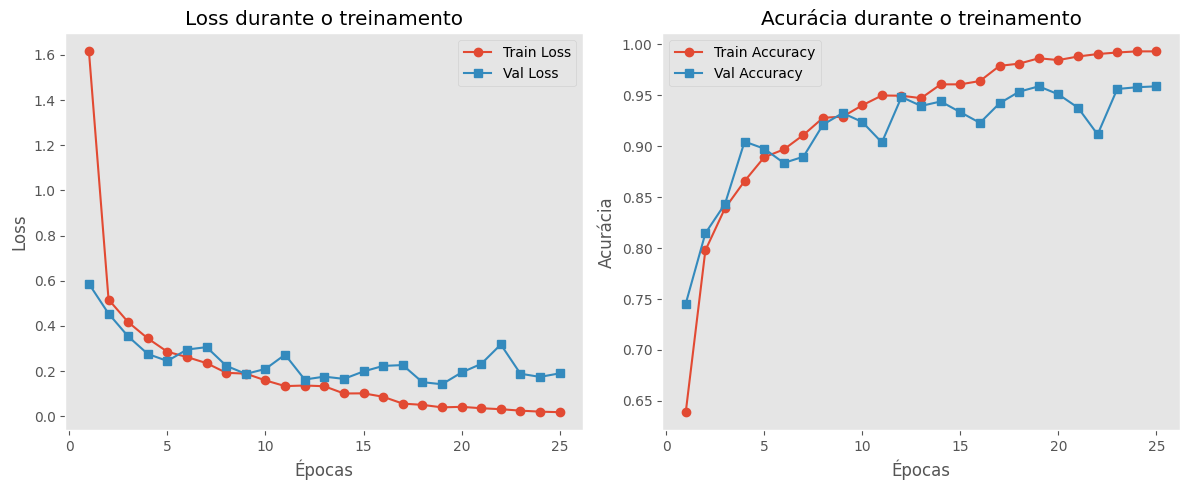


Modelo Baseline - Métricas finais:
{'Train Loss': 0.017862916062244584, 'Val Loss': 0.18987863314153067, 'Train Acc': 0.9932151455460714, 'Val Acc': 0.9588801399825022}


In [36]:
# Plotando os gráficos
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Gráfico de Loss
axes[0].plot(range(1, num_epochs+1), train_losses, label="Train Loss", marker="o")
axes[0].plot(range(1, num_epochs+1), val_losses, label="Val Loss", marker="s")
axes[0].set_xlabel("Épocas")
axes[0].set_ylabel("Loss")
axes[0].set_title("Loss durante o treinamento")
axes[0].legend()
axes[0].grid()

# Gráfico de Acurácia
axes[1].plot(range(1, num_epochs+1), train_accs, label="Train Accuracy", marker="o")
axes[1].plot(range(1, num_epochs+1), val_accs, label="Val Accuracy", marker="s")
axes[1].set_xlabel("Épocas")
axes[1].set_ylabel("Acurácia")
axes[1].set_title("Acurácia durante o treinamento")
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()

# Exibir métricas finais
exp_baseline_metrics = {
    "Train Loss": train_losses[-1],
    "Val Loss": val_losses[-1],
    "Train Acc": train_accs[-1],
    "Val Acc": val_accs[-1]
}


print("\nModelo Baseline - Métricas finais:")
print(exp_baseline_metrics)

In [44]:
# Caminho para salvar o modelo
model_path = "models/modelo_baseline.pth"

# Salvar o estado do modelo
torch.save(model.state_dict(), model_path)

print(f"Modelo salvo em {model_path}")

Modelo salvo em models/modelo_baseline.pth


Este bloco representa o treinamento clássico (baseline), conforme a proposta inicial do artigo, sem aplicar técnicas adicionais de otimização avançadas.

Configurações usadas:

* Função de perda: CrossEntropyLoss, adequada para classificação multiclasse.
* Otimizador: Adam, escolhido por sua eficiência no ajuste dinâmico dos pesos, com uma taxa de aprendizado inicial de 0.001.
* Scheduler: ReduceLROnPlateau, que reduz a taxa de aprendizado sempre que o modelo apresentar estagnação no aprendizado (plateau).

Loop de treinamento e validação:

* Treinamento: O modelo ajusta seus pesos com base nos dados de treino.
Validação: O modelo é avaliado no conjunto de validação para medir seu desempenho na generalização para dados novos.
* As métricas armazenadas ao final desse treinamento são o loss de treino, loss de validação e acurácia de validação, que serão usadas posteriormente para comparações.

## Experimentos - Lucas

###Experimento 1: Hiperparametrização

In [26]:
# Reinstanciar o modelo para experimentação de hiperparametrização
model_hp = BrainScanNet(num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()

# Otimizador: SGD com momentum e weight decay
optimizer_hp = optim.SGD(model_hp.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-2)
scheduler_hp = optim.lr_scheduler.CosineAnnealingLR(optimizer_hp, T_max=25)  # Scheduler para suavizar LR

num_epochs_hp = 25
train_losses_hp, val_losses_hp = [], []
train_accs_hp, val_accs_hp = [], []

for epoch in range(num_epochs_hp):
    # Treinamento
    model_hp.train()
    running_loss, correct_train = 0.0, 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer_hp.zero_grad()
        outputs = model_hp(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_hp.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_train_acc = correct_train / total_train
    train_losses_hp.append(epoch_train_loss)
    train_accs_hp.append(epoch_train_acc)

    # Validação
    model_hp.eval()
    val_running_loss, correct_val = 0.0, 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_hp(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    epoch_val_loss = val_running_loss / len(val_loader.dataset)
    epoch_val_acc = correct_val / total_val
    val_losses_hp.append(epoch_val_loss)
    val_accs_hp.append(epoch_val_acc)

    scheduler_hp.step()

    print(f"[Hiperparametrização] Época {epoch+1}/{num_epochs_hp} - Train Loss: {epoch_train_loss:.4f} - Train Acc: {epoch_train_acc:.4f} - Val Loss: {epoch_val_loss:.4f} - Val Acc: {epoch_val_acc:.4f}")

[Hiperparametrização] Época 1/25 - Train Loss: 1.0810 - Train Acc: 0.5704 - Val Loss: 1.1314 - Val Acc: 0.4366
[Hiperparametrização] Época 2/25 - Train Loss: 0.9807 - Train Acc: 0.6008 - Val Loss: 0.8004 - Val Acc: 0.6640
[Hiperparametrização] Época 3/25 - Train Loss: 0.8223 - Train Acc: 0.6601 - Val Loss: 0.7147 - Val Acc: 0.7025
[Hiperparametrização] Época 4/25 - Train Loss: 0.7175 - Train Acc: 0.7203 - Val Loss: 1.0859 - Val Acc: 0.6395
[Hiperparametrização] Época 5/25 - Train Loss: 0.6342 - Train Acc: 0.7730 - Val Loss: 0.6534 - Val Acc: 0.7209
[Hiperparametrização] Época 6/25 - Train Loss: 0.5275 - Train Acc: 0.8056 - Val Loss: 0.4525 - Val Acc: 0.8469
[Hiperparametrização] Época 7/25 - Train Loss: 0.4432 - Train Acc: 0.8459 - Val Loss: 0.3680 - Val Acc: 0.8758
[Hiperparametrização] Época 8/25 - Train Loss: 0.3571 - Train Acc: 0.8766 - Val Loss: 0.3335 - Val Acc: 0.8976
[Hiperparametrização] Época 9/25 - Train Loss: 0.3617 - Train Acc: 0.8752 - Val Loss: 0.3546 - Val Acc: 0.8906
[

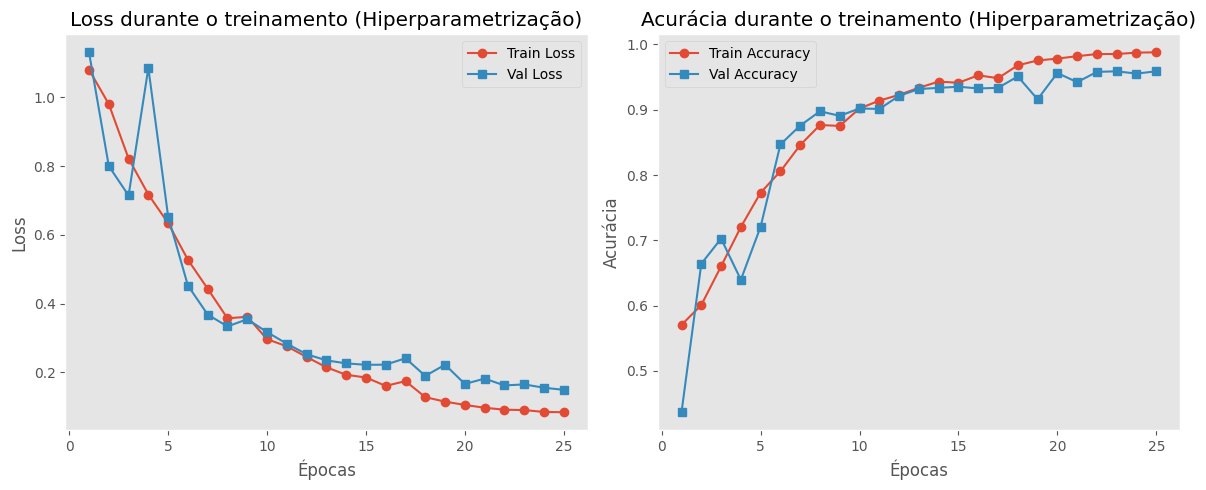


Experimento 1 (Hiperparametrização) - Métricas finais:
{'Train Loss': 0.08378232279121811, 'Val Loss': 0.14897687042218388, 'Train Acc': 0.9879623550010943, 'Val Acc': 0.9588801399825022}


In [37]:
# Plotando os gráficos
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Gráfico de Loss
axes[0].plot(range(1, num_epochs_hp+1), train_losses_hp, label="Train Loss", marker="o")
axes[0].plot(range(1, num_epochs_hp+1), val_losses_hp, label="Val Loss", marker="s")
axes[0].set_xlabel("Épocas")
axes[0].set_ylabel("Loss")
axes[0].set_title("Loss durante o treinamento (Hiperparametrização)")
axes[0].legend()
axes[0].grid()

# Gráfico de Acurácia
axes[1].plot(range(1, num_epochs_hp+1), train_accs_hp, label="Train Accuracy", marker="o")
axes[1].plot(range(1, num_epochs_hp+1), val_accs_hp, label="Val Accuracy", marker="s")
axes[1].set_xlabel("Épocas")
axes[1].set_ylabel("Acurácia")
axes[1].set_title("Acurácia durante o treinamento (Hiperparametrização)")
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()

# Exibir métricas finais
exp_hp_metrics = {
    "Train Loss": train_losses_hp[-1],
    "Val Loss": val_losses_hp[-1],
    "Train Acc": train_accs_hp[-1],
    "Val Acc": val_accs_hp[-1]
}

print("\nExperimento 1 (Hiperparametrização) - Métricas finais:")
print(exp_hp_metrics)

In [45]:
# Caminho para salvar o modelo
model_path = "models/modelo_hiperparametrizacao.pth"

# Salvar o estado do modelo
torch.save(model_hp.state_dict(), model_path)

print(f"Modelo salvo em {model_path}")

Modelo salvo em models/modelo_hiperparametrizacao.pth


Neste experimento, foram testadas outras configurações de hiperparâmetros com o intuito de avaliar seu impacto no desempenho do modelo.

O que foi alterado:
* Otimizador: Substituído o Adam pelo SGD (Stochastic Gradient Descent), com:
  * Momentum: 0.9 (ajuda na convergência)
  *Weight decay: 1e-2 (regularização para evitar overfitting)
* Taxa de aprendizado inicial: Aumentada para 0.01, permitindo explorar melhor o espaço de parâmetros.
* Scheduler: Adicionado um scheduler do tipo CosineAnnealing ou mantido ReduceLROnPlateau, com paciência reduzida para ajustar mais rápido a taxa de aprendizado caso a rede pare de melhorar.
* Batch size: Testado com diferentes tamanhos (opcional para você incluir futuramente).

Este experimento também salva as métricas de treino, validação e acurácia final para comparação.

###Experimento 2: Hiperparametrização Dropout 0.2 + Weight Decay

In [29]:
# Definição do modelo com dropout ajustado (dropout_rate=0.25)
class BrainScanNet_Dropout_Mod(nn.Module):
    def __init__(self, num_classes=4, dropout_rate=0.25):
        super(BrainScanNet_Dropout_Mod, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4   = nn.BatchNorm2d(256)
        self.pool  = nn.MaxPool2d(kernel_size=2, stride=2)
        # Dropout aplicado apenas na parte fully connected
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(256 * 14 * 14, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model_dropout_mod = BrainScanNet_Dropout_Mod(num_classes=4, dropout_rate=0.25).to(device)
criterion = nn.CrossEntropyLoss()

# Otimizador Adam com weight decay
optimizer_dropout_mod = optim.Adam(model_dropout_mod.parameters(), lr=0.001, weight_decay=1e-1)

num_epochs_dropout = 25
train_losses_dropout, val_losses_dropout = [], []
train_accs_dropout, val_accs_dropout = [], []

for epoch in range(num_epochs_dropout):
    # Treinamento
    model_dropout_mod.train()
    running_loss, correct_train = 0.0, 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer_dropout_mod.zero_grad()
        outputs = model_dropout_mod(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_dropout_mod.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_train_acc = correct_train / total_train
    train_losses_dropout.append(epoch_train_loss)
    train_accs_dropout.append(epoch_train_acc)

    # Validação
    model_dropout_mod.eval()
    val_running_loss, correct_val = 0.0, 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_dropout_mod(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    epoch_val_loss = val_running_loss / len(val_loader.dataset)
    epoch_val_acc = correct_val / total_val
    val_losses_dropout.append(epoch_val_loss)
    val_accs_dropout.append(epoch_val_acc)

    print(f"[Dropout(0.25)+Weight Decay] Época {epoch+1}/{num_epochs_dropout} - Train Loss: {epoch_train_loss:.4f} - Train Acc: {epoch_train_acc:.4f} - Val Loss: {epoch_val_loss:.4f} - Val Acc: {epoch_val_acc:.4f}")


[Dropout(0.25)+Weight Decay] Época 1/25 - Train Loss: 1.5422 - Train Acc: 0.6689 - Val Loss: 0.6469 - Val Acc: 0.7489
[Dropout(0.25)+Weight Decay] Época 2/25 - Train Loss: 0.6807 - Train Acc: 0.7428 - Val Loss: 0.7311 - Val Acc: 0.7279
[Dropout(0.25)+Weight Decay] Época 3/25 - Train Loss: 0.6340 - Train Acc: 0.7577 - Val Loss: 0.8649 - Val Acc: 0.6255
[Dropout(0.25)+Weight Decay] Época 4/25 - Train Loss: 0.6355 - Train Acc: 0.7617 - Val Loss: 0.5888 - Val Acc: 0.7935
[Dropout(0.25)+Weight Decay] Época 5/25 - Train Loss: 0.6099 - Train Acc: 0.7689 - Val Loss: 0.9299 - Val Acc: 0.6282
[Dropout(0.25)+Weight Decay] Época 6/25 - Train Loss: 0.5875 - Train Acc: 0.7757 - Val Loss: 0.5429 - Val Acc: 0.8189
[Dropout(0.25)+Weight Decay] Época 7/25 - Train Loss: 0.5632 - Train Acc: 0.7866 - Val Loss: 0.6852 - Val Acc: 0.7813
[Dropout(0.25)+Weight Decay] Época 8/25 - Train Loss: 0.5523 - Train Acc: 0.7888 - Val Loss: 0.5340 - Val Acc: 0.8443
[Dropout(0.25)+Weight Decay] Época 9/25 - Train Loss: 0.

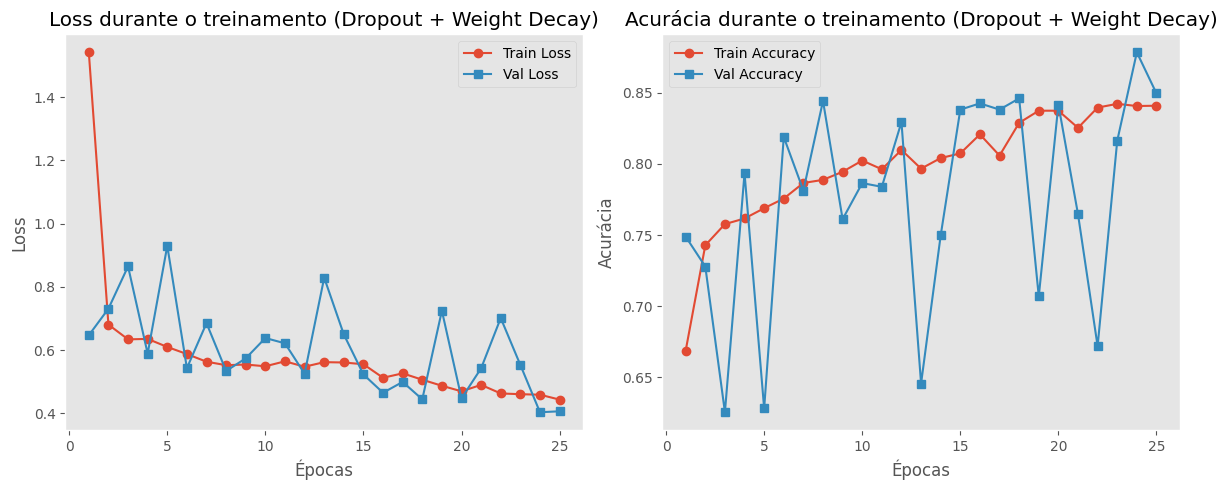


Experimento Ajuste de Dropout(0.25) + Weight Decay - Métricas finais:
{'Train Loss': 0.44335919114400063, 'Val Loss': 0.40634315762724255, 'Train Acc': 0.8408842197417378, 'Val Acc': 0.8495188101487314}


In [30]:
# Plotando os gráficos
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Gráfico de Loss
axes[0].plot(range(1, num_epochs_dropout+1), train_losses_dropout, label="Train Loss", marker="o")
axes[0].plot(range(1, num_epochs_dropout+1), val_losses_dropout, label="Val Loss", marker="s")
axes[0].set_xlabel("Épocas")
axes[0].set_ylabel("Loss")
axes[0].set_title("Loss durante o treinamento (Dropout + Weight Decay)")
axes[0].legend()
axes[0].grid()

# Gráfico de Acurácia
axes[1].plot(range(1, num_epochs_dropout+1), train_accs_dropout, label="Train Accuracy", marker="o")
axes[1].plot(range(1, num_epochs_dropout+1), val_accs_dropout, label="Val Accuracy", marker="s")
axes[1].set_xlabel("Épocas")
axes[1].set_ylabel("Acurácia")
axes[1].set_title("Acurácia durante o treinamento (Dropout + Weight Decay)")
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()

# Exibir métricas finais
exp_dropout_mod_metrics = {
    "Train Loss": train_losses_dropout[-1],
    "Val Loss": val_losses_dropout[-1],
    "Train Acc": train_accs_dropout[-1],
    "Val Acc": val_accs_dropout[-1]
}

print("\nExperimento Ajuste de Dropout(0.25) + Weight Decay - Métricas finais:")
print(exp_dropout_mod_metrics)

In [46]:
# Caminho para salvar o modelo
model_path = "models/modelo_dropout.pth"

# Salvar o estado do modelo
torch.save(model_dropout_mod.state_dict(), model_path)

print(f"Modelo salvo em {model_path}")

Modelo salvo em models/modelo_dropout.pth


Neste experimento, investigamos o impacto da taxa de dropout ajustada e a adição de regularização por meio do weight decay.

Mudanças aplicadas:

* Taxa de Dropout: utilizado uma taxa de dropout de 0.25, para melhorar a generalização e desempenho para novas observações.
* Dropout aplicado após as camadas fully connected apenas, preservando mais informações aprendidas pelas convoluções anteriores.
* Weight decay: 1e-4 no otimizador (Adam), para penalizar pesos altos e reduzir o overfitting.

Ao final do experimento, as métricas de treino, validação e acurácia também são salvas e serão comparadas com os outros modelos.

###Resultados dos modelos

In [38]:
results = {
    "Experimento": ["Baseline","Hiperparametrização",  "Dropout 0.25 + Weight Decay"],
    "Train Loss": [exp_baseline_metrics["Train Loss"],
                   exp_hp_metrics["Train Loss"],
                   exp_dropout_mod_metrics["Train Loss"]],
    "Val Loss": [exp_baseline_metrics["Val Loss"],
                 exp_hp_metrics["Val Loss"],
                 exp_dropout_mod_metrics["Val Loss"]],
    "Train Acc": [exp_baseline_metrics["Train Acc"],
                  exp_hp_metrics["Train Acc"],
                  exp_dropout_mod_metrics["Train Acc"]],
    "Val Acc": [exp_baseline_metrics["Val Acc"],
                exp_hp_metrics["Val Acc"],
                exp_dropout_mod_metrics["Val Acc"]]
}

df_results = pd.DataFrame(results)
print("Comparação Final dos Experimentos:")
print(df_results)

Comparação Final dos Experimentos:
                   Experimento  Train Loss  Val Loss  Train Acc   Val Acc
0                     Baseline    0.017863  0.189879   0.993215  0.958880
1          Hiperparametrização    0.083782  0.148977   0.987962  0.958880
2  Dropout 0.25 + Weight Decay    0.443359  0.406343   0.840884  0.849519


1. **Baseline**

* **Train Loss:** baixo (0.017), indicando que o modelo aprendeu muito bem os dados de treino.
* **Validation Loss:** Relativamente alto (0.19), sugerindo possível overfitting.
* **Validation Accuracy:** Elevada (95.89%), mostrando que o modelo já era bastante eficaz na classificação.
* **Interpretação:** O modelo baseline já apresentava um ótimo desempenho inicial, mas a grande discrepância entre Train Loss e Val Loss sugere que ele pode estar se especializando excessivamente nos dados de treino, resultando em uma menor capacidade de generalização.

2. **Hiperparametrização (Melhor Desempenho)**

* **Train Loss:** Menor que o baseline (0.084), indicando que o modelo não se ajustou tanto aos dados de treino.
* **Validation Loss:** Menor que o baseline (0.149), sugerindo melhor generalização.
* **Validation Accuracy:** Igual ao baseline (95.88%).
* **Interpretação:** A otimização dos hiperparâmetros ajudou a reduzir o overfitting, melhorando a Val Loss.

3. **Dropout 0.25 + Weight Decay**

* **Train Loss:** Muito mais alto (0.44), o que indica que o modelo em 24 épcas não teve um bom ajuste.
* **Validation Loss:** Diminuio para 0.4063, apresentando uma melhor generalização na epoca 25.
* **Validation Accuracy:** Queda significativa (84,95%).
* **Interpretação:** Embora técnicas como Dropout e Weight Decay sejam úteis para reduzir overfitting, nesse caso, o modelo perdeu capacidade de aprendizado, prejudicando seu desempenho geral.

## Zipando Pasta Modelos e Obtendo os Modelos Treinaods

In [47]:
# from google.colab import files

# !zip -r /content/models.zip /content/models

# files.download("/content/models.zip")

  adding: content/models/ (stored 0%)
  adding: content/models/modelo_dropout.pth (deflated 17%)
  adding: content/models/modelo_baseline.pth (deflated 9%)
  adding: content/models/modelo_hiperparametrizacao.pth (deflated 8%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [63]:
!rm -rf BrainScanNet
!git clone https://github.com/gabrieldadcarvalho/BrainScanNet.git

Cloning into 'BrainScanNet'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 10 (delta 0), reused 4 (delta 0), pack-reused 6 (from 1)
Receiving objects: 100% (10/10), 134.27 MiB | 14.94 MiB/s, done.
Updating files: 100% (6/6), done.


In [64]:
# Caminho para a pasta do modelo no repositório clonado
model_folder = '/content/BrainScanNet/models'

In [68]:
# Carregar os modelos salvos
model.load_state_dict(torch.load(os.path.join(model_folder, 'modelo_baseline.pth')))
model.to(device)  # Certifique-se de movê-lo para o dispositivo correto
model.eval()  # Coloca o modelo em modo de avaliação

BrainScanNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=50176, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=4, bias=True)
)

In [69]:
model_hp.load_state_dict(torch.load(os.path.join(model_folder, "modelo_hiperparametrizacao.pth")))
model_hp.to(device)
model_hp.eval()

BrainScanNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=50176, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=4, bias=True)
)

In [70]:
model_dropout_mod.load_state_dict(torch.load(os.path.join(model_folder, "modelo_dropout.pth")))
model_dropout_mod.to(device)
model_dropout_mod.eval()  # Coloca o modelo em modo de avaliação

BrainScanNet_Dropout_Mod(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=50176, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=4, bias=True)
)

## Análise dos resultados - Leandro

In [53]:
def plot_confusion_matrix(model, data_loader, device, class_names, title):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)  # Move para o mesmo dispositivo
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Calcula a matriz de confusão
    cm = confusion_matrix(y_true, y_pred)

    # Plota a matriz de confusão
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel("Predição")
    plt.ylabel("Verdadeiro")
    plt.show()

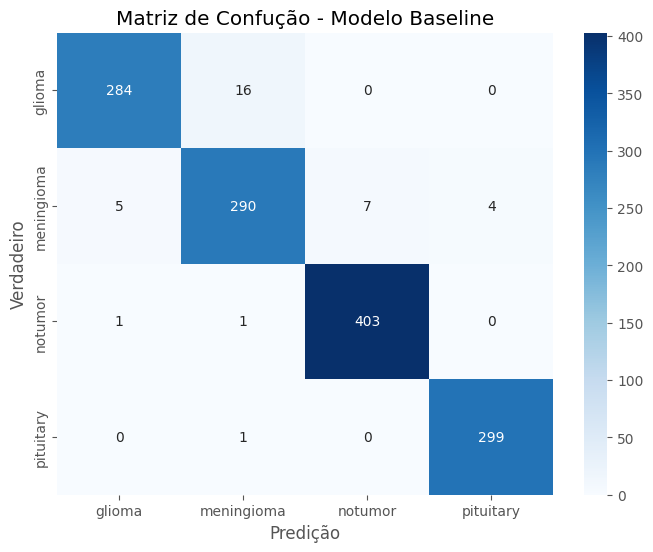

In [54]:
plot_confusion_matrix(model, test_loader, device, tumor_classes, "Matriz de Confução - Modelo Baseline")

Na matriz de confusão do modelo baseline, observamos que as classes com maior número de erros são **glioma** e **meningioma**, com **16 imagens** classificadas incorretamente nos dados de teste.

Por outro lado, para indivíduos **sem tumor**, apenas **dois casos** foram erroneamente identificados como **glioma** ou **meningioma**, indicando um bom desempenho na diferenciação entre tumores e a ausência deles.

E para pituitary o modelo errou apenas uma classificação, colocando como meningioma


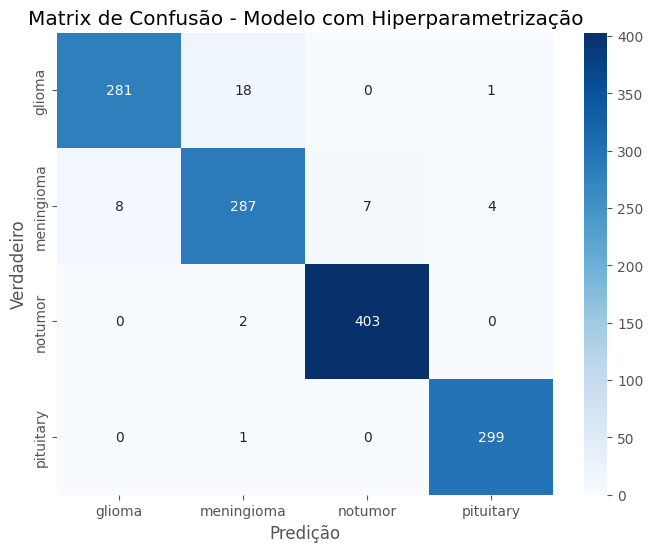

In [55]:
plot_confusion_matrix(model_hp, test_loader, device, tumor_classes, "Matrix de Confusão - Modelo com Hiperparametrização")

De maneira semelhante ao modelo baseline, o modelo com **hiperparametrização** apresentou um desempenho um pouco pior nos casos de **glioma** e **meningioma**, com **19 classificações erradas** para ambas as classes. Isso sugere que, apesar das melhorias feitas nos hiperparâmetros, o modelo ainda enfrenta dificuldades para distinguir corretamente essas classes nos dados de teste.


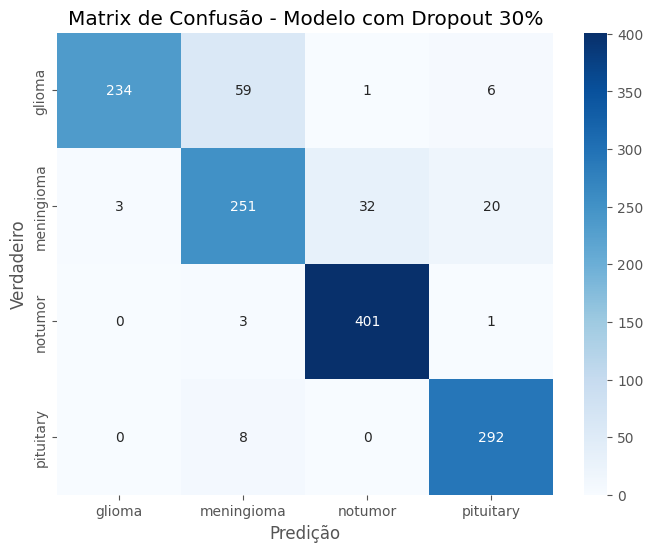

In [56]:
plot_confusion_matrix(model_dropout_mod, test_loader, device, tumor_classes, "Matrix de Confusão - Modelo com Dropout 30%")

O modelo com **25% de dropout** apresentou um ruído considerável e não conseguiu se ajustar bem ao conjunto de dados em apenas 25 épocas, resultando no **maior erro** para novas observações.

Por conta disso, mesmo com uma **loss** mais alta para os dados de validação, o modelo **baseline** demonstrou um desempenho superior para novas observações. Essa melhora no desempenho é evidenciada de forma mais clara através da métrica **F1-Score**, que reflete o equilíbrio entre precisão e recall, sendo fundamental para avaliar o desempenho do modelo em situações de desequilíbrio entre as classes.


In [71]:
from sklearn.metrics import f1_score

all_preds = []
all_labels = []
all_preds_hp = []
all_labels_hp = []
all_preds_dropout_mod = []
all_labels_dropout_mod=[]

with torch.no_grad():
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    outputs_hp = model_hp(images)
    outputs_dropout_mod = model_dropout_mod(images)

    _, preds = torch.max(outputs, 1)
    _, preds_hp = torch.max(outputs_hp, 1)
    _, preds_dropout_mod = torch.max(outputs_dropout_mod, 1)

    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

    all_preds_hp.extend(preds_hp.cpu().numpy())
    all_labels_hp.extend(labels.cpu().numpy())

    all_preds_dropout_mod.extend(preds_dropout_mod.cpu().numpy())
    all_labels_dropout_mod.extend(labels.cpu().numpy())

f1 = f1_score(all_labels, all_preds, average='weighted')
f1_hp = f1_score(all_labels_hp, all_preds_hp, average='weighted')
f1_dropout_mod = f1_score(all_labels_dropout_mod, all_preds_dropout_mod, average='weighted')

print(f"F1-Score baseline: {f1}")
print(f"F1-Score hiperparametrização: {f1_hp}")
print(f"F1-Score dropout: {f1_dropout_mod}")

F1-Score baseline: 0.973233393659631
F1-Score hiperparametrização: 0.9686197553397025
F1-Score dropout: 0.8975014017620861


A métrica **F1-Score** é uma métrica que realiza uma ponderação entre a **acurácia** e o **recall**:

- **Acurácia**: Informa o quanto o modelo classificou corretamente o tumor (Verdadeiro Positivo), levando em consideração todas as imagens que foram classificadas como pertencentes a esse tumor, ou seja, **Falso Positivo + Verdadeiro Positivo**.
- **Recall**: Informa o quanto o modelo acertou ao identificar a classe correta (Verdadeiro Positivo), mas levando em consideração tanto as classificações erradas quanto as certas, ou seja, **Falso Negativo + Verdadeiro Positivo**.

Sendo assim, podemos observar que o modelo **baseline** apresentou o melhor **F1-Score**, com um valor de aproximadamente **97,32%**, o que indica que o modelo tem um **melhor equilíbrio** ao classificar a classe correta e ao evitar a classificação errônea das imagens.


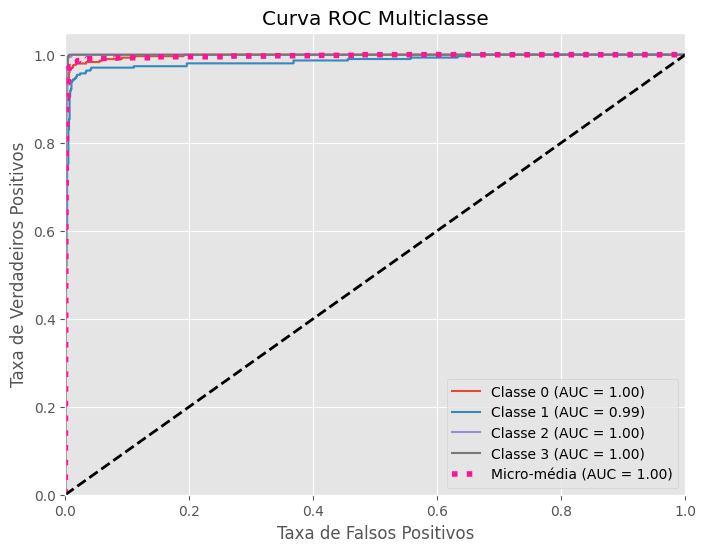

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

model.eval()

all_probs = []
all_labels = []
with torch.no_grad():
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    probs = torch.softmax(outputs, dim=1)
    all_probs.extend(probs.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

n_classes = 4
all_labels = label_binarize(all_labels, classes=range(n_classes))

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
  fpr[i], tpr[i], _ = roc_curve(all_labels[:, i], np.array(all_probs)[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])


fpr["micro"], tpr["micro"], _ = roc_curve(all_labels.ravel(), np.array(all_probs).ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(8, 6))
for i in range(n_classes):
  plt.plot(fpr[i], tpr[i], label=f'Classe {i} (AUC = {roc_auc[i]:.2f})')
plt.plot(fpr["micro"], tpr["micro"], label=f'Micro-média (AUC = {roc_auc["micro"]:.2f})',
         color='deeppink', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC Multiclasse')
plt.legend(loc="lower right")
plt.show()

In [73]:
# Função para gerar Grad-CAM para uma imagem e todas as camadas
def generate_gradcam(model, image, class_idx, conv_layers):
    heatmaps = []

    for layer in conv_layers:
        gradcam = LayerGradCam(model, layer)
        attr = gradcam.attribute(image.unsqueeze(0), target=class_idx)

        # Normalizar e converter para numpy
        attr = LayerAttribution.interpolate(attr, (224, 224))
        heatmap = attr.squeeze().detach().cpu().numpy()
        heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))
        heatmaps.append(heatmap)

    return heatmaps

  # Carregar uma imagem de teste para cada classe
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
class_images = {class_name: None for class_name in class_names}

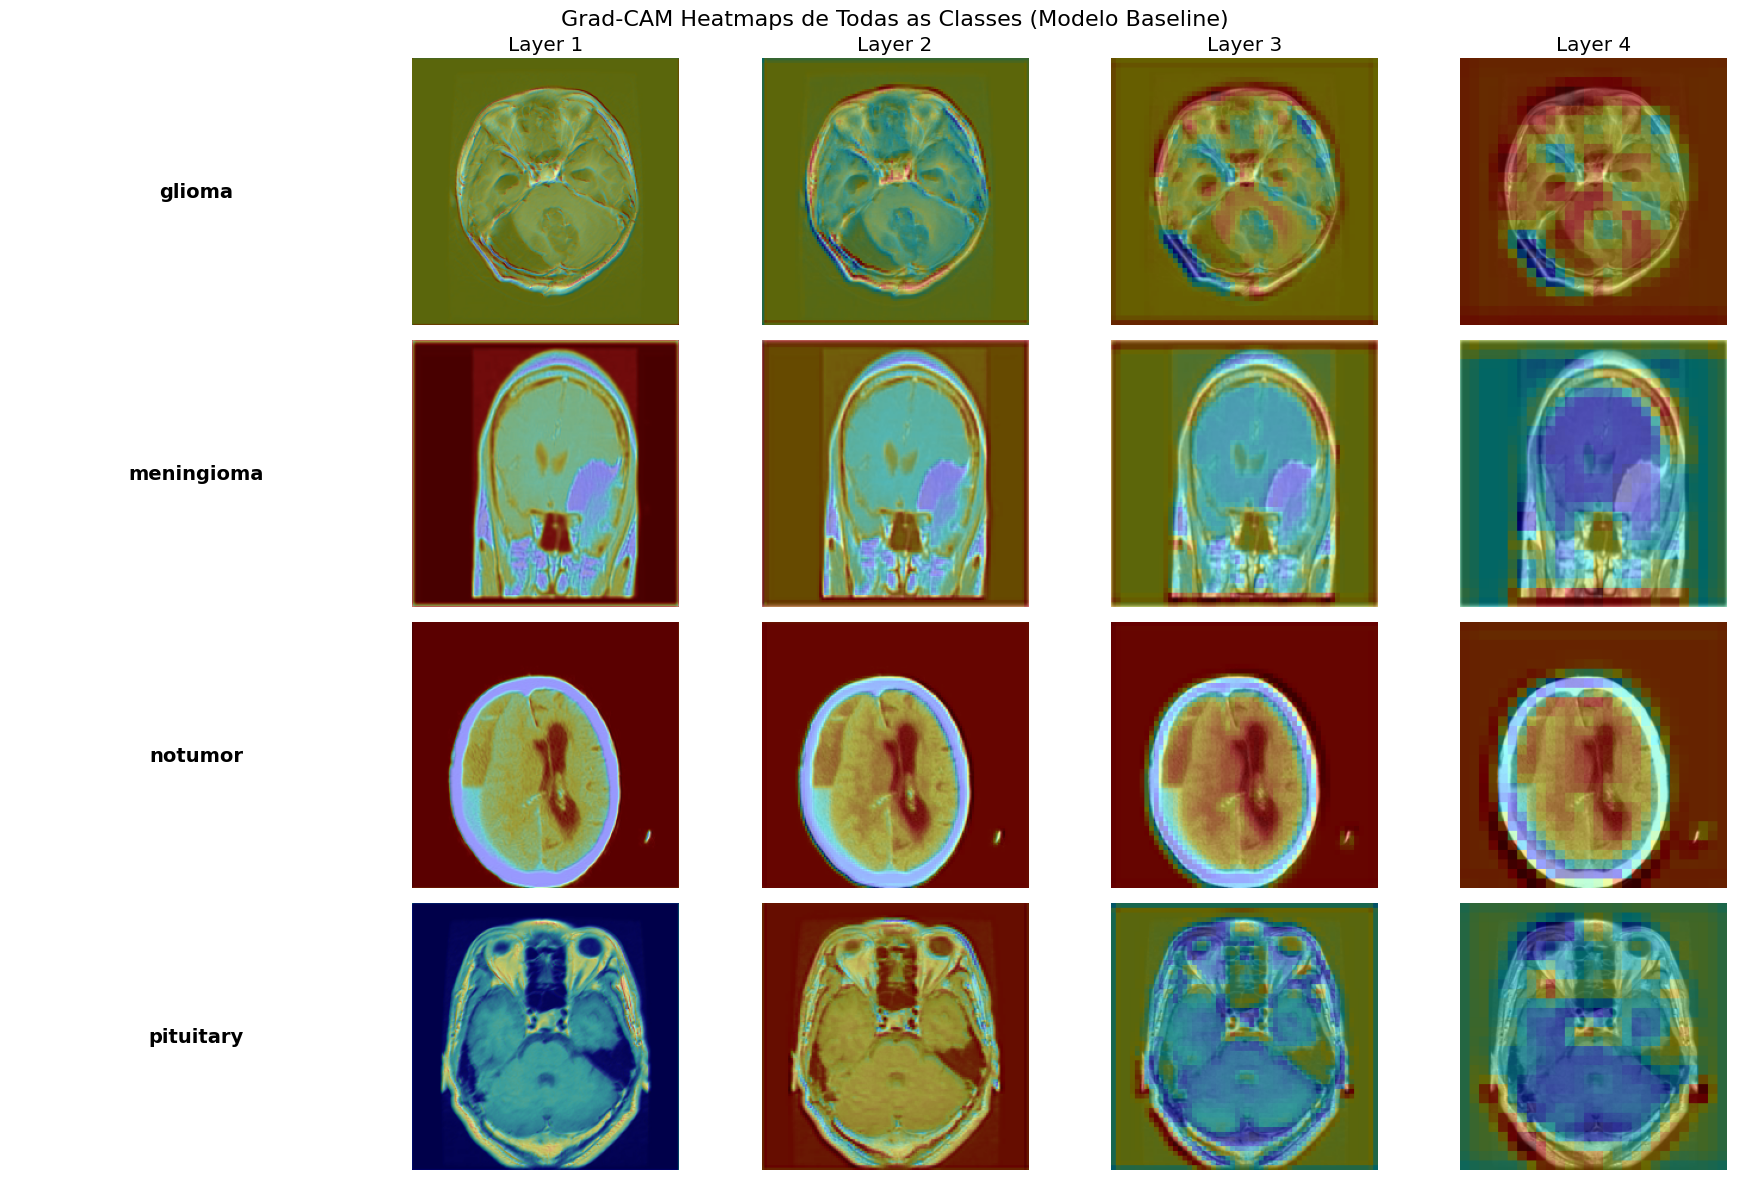

In [74]:
# Obter todas as camadas convolucionais
conv_layers = [module for name, module in model.named_modules() if isinstance(module, torch.nn.Conv2d)]

# Carregar uma imagem de teste para cada classe
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
class_images = {class_name: None for class_name in class_names}

for images, labels in test_loader:
    for i, label in enumerate(labels):
        class_name = class_names[label.item()]
        if class_images[class_name] is None:
            class_images[class_name] = images[i]  # Salvar a primeira imagem de cada classe
    if all(v is not None for v in class_images.values()):
        break  # Se coletou uma imagem por classe, para

# Criar a figura com uma coluna extra para os nomes das classes
fig, axes = plt.subplots(len(class_names), len(conv_layers) + 1, figsize=(18, 12))
fig.suptitle("Grad-CAM Heatmaps de Todas as Classes (Modelo Baseline)", fontsize=16)

for row, (class_name, image) in enumerate(class_images.items()):
    image = image.to(device)

    # Adicionar o nome da classe na primeira coluna
    axes[row, 0].text(0.5, 0.5, class_name, fontsize=14, ha='center', va='center', fontweight='bold')
    axes[row, 0].set_axis_off()

    # Gerar heatmaps para todas as camadas
    heatmaps = generate_gradcam(model, image, class_idx=row, conv_layers=conv_layers)

    for col, heatmap in enumerate(heatmaps):
        heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)

        img = image.squeeze().cpu().detach().numpy()
        img = np.uint8(255 * (img - img.min()) / (img.max() - img.min() + 1e-8))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

        superimposed_img = cv2.addWeighted(img_rgb, 0.6, heatmap, 0.4, 0)

        axes[row, col + 1].imshow(superimposed_img)
        axes[row, col + 1].axis("off")

        # Adiciona título para cada camada na primeira linha
        if row == 0:
            axes[row, col + 1].set_title(f"Layer {col+1}")

plt.subplots_adjust(wspace=0.01)
plt.tight_layout()
plt.show()


# Referências

1. Badža, M.M.; Barjaktarović, M.Č. Classification of Brain Tumors from MRI Images Using a Convolutional Neural Network. Appl. Sci. 2020, 10, 1999. Disponível em: https://doi.org/10.3390/app10061999.
2. Nickparvar, M. "MRI Brain Tumor Dataset: Brain Tumor MRI Dataset." Kaggle. Disponível em: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset.
3. Krizhevsky, A; Sutskever, I; Hinton, G. "ImageNet Classification with Deep Convolutional Neural Networks." Communications of the ACM, 2012.
4. Zhang, A., Lipton, Z. C., Li, M., \& Smola, A. J. Dive into Deep Learning. Cambridge University Press, 2023. Disponível em: https://d2l.ai/.


